# DLO-JZ Profiler, DataLoader - Jour 2 - après midi 

![car](./images/noun-car-repair-32305.png)




## Objet du notebook

Le but de ce *notebook* est d'optimiser la *DataLoader* afin de ne pas ralentir la boucle d'apprentissage. L'étude de la performance des solutions optimisées se fera en visualisant les traces du *profiler* :
* **TP 3** : Profiler
* **TP 4** : Optimisation du DataLoader

Les cellules dans ce *notebook* ne sont pas prévues pour être modifiées, sauf rares exceptions indiquées dans les commentaires. Les TP se feront en modifiant le code `dlojz.py`.

Les directives de modification seront marquées par l'étiquette **TODO :** dans le *notebook* suivant.
 
Les solutions sont présentes dans le répertoire `solutions`.

*Notebook rédigé par l'équipe assistance IA de l'IDRIS, juin 2023*

------------------------

### Environnement de calcul

Un module PyTorch doit avoir été chargé pour le bon fonctionnement de ce Notebook. **Nécessairement**, le module `pytorch-gpu/py3/1.11.0` :

In [ ]:
!module list

Les fonctions *python* de gestion de queue SLURM dévelopées par l'IDRIS et les fonctions dédiées à la formation DLO-JZ sont à importer.

Le module d'environnement pour les *jobs* et la taille des images sont fixés pour ce *notebook*.

**TODO :** choisir un *pseudonyme* (maximum 5 caractères) pour vous différencier dans la queue SLURM et dans les outils collaboratifs pendant la formation et la compétition.

In [ ]:
from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from dlojz_tools import controle_technique, compare, GPU_underthehood, plot_accuracy, lrfind_plot, imagenet_starter, turbo_profiler
MODULE = 'pytorch-gpu/py3/1.11.0'
account = 'for@v100'
name = 'pseudo'   ## Pseudonyme à choisir

------------------------------------

### Gestion de la queue SLURM

Cette partie permet d'afficher et de gérer la queue SLURM.

Pour afficher toute la queue *utilisateur* :

In [ ]:
display_slurm_queue(name)

**Remarque**: Cette fonction utilisée plusieurs fois dans ce *notebook* permet d'afficher la queue de manière dynamique, rafraichie toutes les 5 secondes. Cependant elle ne s'arrête que lorsque la queue est vide. Si vous désirez reprendre la main sur le *notebook*, il vous suffira d'arrêter manuellement la cellule avec le bouton *stop*. Cela a bien sûr aucun impact sur le *scheduler* SLURM. Les *jobs* ne seront pas arrêtés.

Si vous voulez annuler un *job* dans votre queue, décommenter la ligne suivante et remplacer le numéro du *job*.


In [ ]:
#!scancel 2088207

------------------------------------

### Debug

Cette partie *debug* permet d'afficher les fichiers de sortie et les fichiers d'erreur du *job*.

Il est nécessaire dans la cellule suivante d'indiquer le *jobid* correspondant sous le format donné.

***Remarque*** : dans ce notebook, lorsque vous soumettrez un *job*, vous recevrez en retour le numéro du job dans le format suivant : `jobid = ['123456']`. La cellule ci-dessous peut ainsi être facilement actualisée.

In [ ]:
#jobid = ['2088207']

Fichier de sortie :

In [ ]:
%cat {search_log(contains=jobid[0])[0]}

Fichier d'erreur :

In [ ]:
%cat {search_log(contains=jobid[0], with_err=True)['stderr'][0]}

--------------

### Différence entre deux scripts

Pour le *debug* ou pour comparer son code avec les solutions mises à disposition, la fonction suivante permet d'afficher une page html contenant un différentiel de fichiers texte.

In [ ]:
s1 = "dlojz.py"
s2 = "./solutions/dlojz2_1.py"
compare(s1, s2)

Voir le résultat du différentiel de fichiers sur la page suivante (attention au spoil !) :

[compare.html](compare.html)

----------------------
## Garage - Mise à niveau

On fixe le *batch size* et la taille d'image pour ce TP.

In [ ]:
bs_optim = 512
image_size = 176

**TODO :** Comparer votre script `dlojz.py` avec ce qu'il devrait être actuellement. Si il y a des divergences, veuillez les corriger (par exemple en copiant-collant la solution).

In [ ]:
s1 = "dlojz.py"
s2 = "./solutions/dlojz2_2.py"
compare(s1, s2)

Voir le résultat du différentiel de fichiers sur la page suivante :

[compare.html](compare.html)

In [ ]:
# copier/coller la solution si nécessaire
#!cp solutions/dlojz2_2.py dlojz.py

# TP2_3 : Profiler

### Implémentation du profiler PyTorch
**TODO** : implémenter le profiler natif PyTorch dans le script `dlojz.py` :
* Importer les fonctionnalités liées au *Profiler Pytorch*.

```python
   	from torch.profiler import profile, tensorboard_trace_handler, ProfilerActivity, schedule
```

* Dans la définition des arguments du script, ajouter l'option `--prof`.

```python
    parser.add_argument('--prof', default=False, action='store_true', help='PROF implementation')
```

* Avant la boucle d'apprentissage, définir un *context* `prof` avec les paramètres du *profiler*. `contextlib.nullcontext()` définit un *context null* lorsque l'on utilise pas le *Profiler*.

```python
    # Pytorch profiler setup
	prof =  profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                    schedule=schedule(wait=1, warmup=1, active=12, repeat=1),
                    on_trace_ready=tensorboard_trace_handler('./profiler/' + os.environ['SLURM_JOB_NAME'] 
                                               + '_' + os.environ['SLURM_JOBID'] + '_bs' +
                                               str(mini_batch_size)  + '_is' + str(args.image_size)),
                    profile_memory=True,
                    record_shapes=False, 
                    with_stack=False,
                    with_flops=False
                    ) if args.prof else contextlib.nullcontext()
```

* Puis englober toute la boucle d'apprentissage (validation comprise) dans le *context* `prof`.

```python
    #### TRAINING ############
    with prof:
        for epoch in range(args.epochs):
            ...
```

* Indiquer au *profiler* la fin de chaque itération d'apprentissage (avant la validation).
```python
    # profiler update
    if args.prof: prof.step()
```

### Génération d'une trace profiler
Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

__Remarques__ : 
* le profilage étant effectué sur une douzaine de *steps*, nous n'exécutons l'entraînement que sur 15 steps grâce à l'argument `--test-nsteps=15`
* les arguments `--num-workers 0 --no-persistent-workers --no-pin-memory --no-non-blocking --prefetch-factor 2` utilisés dans la commande ci-dessous servent à supprimer certaines optimisations déjà présentes dans le script `dlojz.py`. Ces optimisations seront détaillées dans le prochain chapitre du cours.


Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1586932']

**TODO** : vérifier qu'une trace a bien été générée dans le répertoire `profiler/<name>_<jobid>_bs512_is176/` sous la forme d'un fichier `.json`:

In [ ]:
!ls profiler/{name}_{jobid[0]}*

### Visualisation des traces profiler avec TensorBoard <a id="visu_tensorboard_gpu"></a>

**TODO** : visualiser cette trace grâce à l'application TensorBoard en suivant les étapes suivantes :
* ouvrir [jupyterhub.idris.fr](https://jupyterhub.idris.fr) dans un nouvel onglet du navigateur
* ouvrir une nouvelle instance JupyterHub en cliquant sur ***Add New JupyterLab Instance***
* demander la configuration suivante avec **réservation d'un GPU** : 
<div>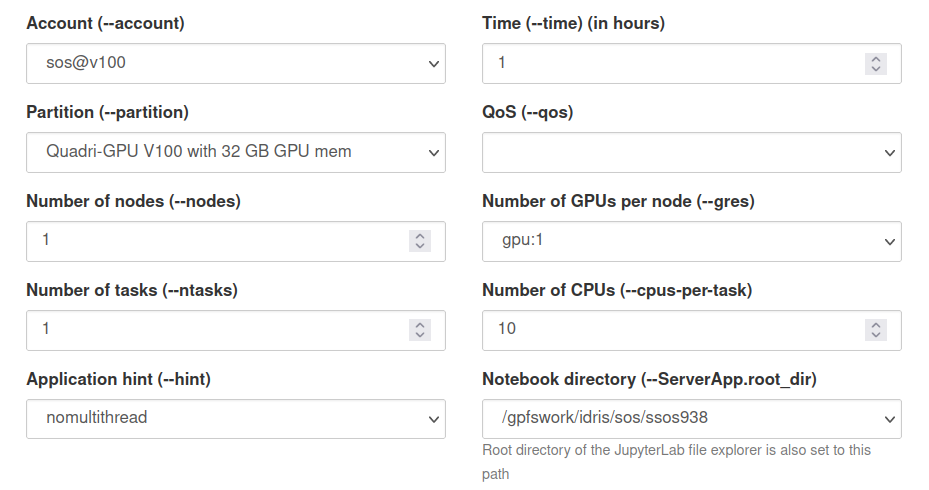</div>

* **charger le module `pytorch-gpu/py3/1.11.0`** via l'onglet **Softwares** (icône bleue sur le menu de gauche)
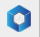 
* ouvrir l'application **Tensorboard** en cliquant sur l'icône correspondante 
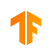
* dans la fenêtre pop-up, définir l'argument CLI `--logdir $WORK/DLO-JZ/profiler` et cliquer sur *Launch*

__Remarque__ : le premier démarrage de TensorBoard peut prendre un peu de temps. Il faut parfois faire preuve d'un peu de patience lorsqu'on utilise cet outil mais ça en vaut la peine :)

**TODO** : en naviguant dans les différents onglets du TensorBoard, chercher à répondre aux questions suivantes :
* le GPU est-il bien utilisé ? (mémoire max utilisée, *occupancy*, *efficiency*)
* la mémoire CPU est-elle saturée ?
* les *TensorCores* sont-ils bien sollicités grâce à l'implémentation de la *mixed precision* ?
* quelle partie de l'entraînement est la plus gourmande en temps ? se déroule-t-elle sur le CPU ou le GPU ?
* essayer de repérer les grandes étapes de calcul sur la *timeline* de l'exécution (onglet *Trace*)

**IMPORTANT** : une fois le TP terminé, penser à quitter l'instance JupyterHub pour **libérer le GPU** ( *> Hub Control Panel > Cancel* ).

![Garage](images/stop.png "Arrêtez-vous ici! Une présentation vous attend avant le prochain TP.")

# TP2_4 : Optimisation du DataLoader

### Contrôle technique (version sous-optimisée)

**TODO** : lancer l'exécution sur 50 itérations (`--test-nsteps 50`) sans profiling pour passer un contrôle technique qui servira de référence. **Cette exécution va prendre quelques minutes, vous pouvez passer à la suite du TP sans attendre la fin de l'exécution.**

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1587014']

In [ ]:
controle_technique(jobid)

### Découverte de turbo_profiler
Pour ce TP, nous avons implémenté un profiler maison léger `turbo_profiler` basé sur l'outil `Chronometer` pour visualiser le temps passé sur CPU (DataLoader) et sur GPU (le reste de l'itération). Ce profiler est moins précis mais cela nous permettra de désactiver le profiler PyTorch pour ne pas dégrader les performances et éviter de devoir ouvrir l'outil graphique TensorBoard à chaque fois pour visualiser les informations qui nous intéressent.

**TODO** :  relancer l'exécution précédente en désactivant le profiler PyTorch (sans l'argument `--prof`) et découvrir le profiler `turbo_profiler`.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'eviter de relancer un job par erreur.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1587014']

**TODO** : visualiser la sortie de `turbo_profiler`

In [ ]:
turbo_profiler(jobid)

### Exploration des paramètres d'optimisation du DataLoader
L'objectif de ce TP est de réduire le temps passé sur CPU par le DataLoader.

Les différentes optimisations proposées par le DataLoader de PyTorch sont accessibles dans le script `dlojz.py` via les arguments :
* `--num-workers <num_workers>` (défaut à `10`)
* `--persistent-workers` (défaut) ou `--no-persistent-workers`
* `--pin-memory` (défaut) ou `--no-pin-memory`
* `--non-blocking` (défaut) ou `--no-non-blocking`
* `--prefetch-factor <prefetch_factor>` (défaut à `3`)
* `--drop-last` ou `--no-drop-last` (défaut)

**TODO** : faire varier ces différents paramètres et observer leurs effets grâce au profiler `turbo_profiler`

**Remarque** : pour cette étude, on ne lance les exécutions que sur 15 itérations (`--test-nsteps 15`) pour avancer plus rapidement. 

Les différents essais seront stockés dans une *DataFrame* `dataloader_trials` :

In [ ]:
import pandas as pd
dataloader_trials = pd.DataFrame({"jobid":pd.Series([],dtype=str),
                                  "num_workers":pd.Series([],dtype=int),
                                  "persistent_workers":pd.Series([],dtype=str),
                                  "pin_memory":pd.Series([],dtype=str),
                                  "non_blocking":pd.Series([],dtype=str),
                                  "prefetch_factor":pd.Series([],dtype=int),
                                  "drop_last":pd.Series([],dtype=str),
                                  "loading_time":pd.Series([],dtype=float),
                                  "training_time":pd.Series([],dtype=float)})

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1508799']

In [ ]:
# call turbo_profiler
dataloader_trial = turbo_profiler(jobid,dataloader_info=True)
# store result in "dataloader_trials" DataFrame
dataloader_trials = pd.concat([dataloader_trials,dataloader_trial], ignore_index=True)

In [ ]:
# afficher le tableau récapitulatif, trier par ordre croissant du LOADING_TIME
dataloader_trials.sort_values("loading_time")

In [ ]:
# afficher le tableau récapitulatif, trier par ordre croissant du TRAINING_TIME
dataloader_trials.sort_values("training_time")

### Visualisation des traces profiler avec TensorBoard (version optimisée)
**TODO** : après avoir choisi un lot de paramètres optimal, relancer le job en réactivant le profiler PyTorch (argument d'entrée `--prof`) afin de visualiser les traces sous TensorBoard, et les comparer avec la version non optimale étudiée dans le TP2_0.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

Puis, rebasculer la cellule précédente en mode `Raw NBConvert`, afin d'éviter de relancer un job par erreur.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1732254']

**TODO** : vérifier qu'une trace a bien été générée dans le répertoire `profiler/<name>_<jobid>_bs512_is176/` sous la forme d'un fichier `.json`:

In [ ]:
!ls profiler/{name}_{jobid[0]}*

**TODO** : visualiser cette trace grâce à l'application TensorBoard ([retrouver la procédure](#visu_tensorboard_gpu)). 

**IMPORTANT** : une fois le TP terminé, penser à quitter l'instance JupyterHub pour **libérer le GPU** ( *> Hub Control Panel > Cancel* ).

### Contrôle technique (version optimisée)

**TODO** : lancer l'exécution sur 50 itérations (`--test-nsteps 50`) sans profiling pour passer un nouveau contrôle technique, à comparer avec celui de référence.

Soumission du *job*. **Attention vous sollicitez les noeuds de calcul à ce moment-là**.

Pour soumettre le job, veuillez basculer la cellule suivante du mode `Raw NBConvert` au mode `Code`.

In [ ]:
display_slurm_queue(name)

In [ ]:
#jobid = ['1587014']

In [ ]:
controle_technique(jobid)

![Garage](images/stop.png "Arrêtez-vous ici! Une présentation vous attend avant le prochain TP.")